# COMP47590 - Advanced Machine Learning 

## DQN for Atari Breakout - Learning from an Image Stack
Uses DQN actor-critic agent to train a neural network based player for the Atari Breakout game from Gymnasium. This uses an image stack state representation.

### Initialisation

If using Google colab you need to install packages - comment out lines below.

In [1]:
#!apt install swig cmake ffmpeg
#!apt-get install -y xvfb x11-utils
#!pip install stable-baselines3[extra] pyglet box2d box2d-kengz
#!pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate

For Google colab comment out this cell to make a virtual rendering canvas so render calls work (we still wont; see display!)

In [2]:
#import pyvirtualdisplay
#
#_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
#                                    size=(1400, 900))
#_ = _display.start()

If using Google colab you need to download and unpackage the game roms - comment out lines below.

In [3]:
#import urllib.request
#urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
#!pip install unrar
#!unrar x Roms.rar
#!mkdir rars
#!mv HC\ ROMS.zip   rars
#!mv ROMS.zip  rars
#!python -m atari_py.import_roms rars

Import required packages. 

In [4]:
import gymnasium as gym
import ale_py
import torch
import stable_baselines3 as sb3

import pandas as pd # For data frames and data frame manipulation
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
import numpy as np # For general  numeric operations

import matplotlib.pyplot as plt
%matplotlib inline 

import time # For sleep function to slow down Atari simulations

2025-03-28 10:15:40.781322: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create the Environment

Create the Breakout Environment

In [5]:
env = gym.make('Breakout-v4')

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


To make Atari environmeent accessible to SB3 models we need to add a number of wrappers. SB3 provides a utility function make_atari_env to do this easily. This adds an AtariWrapper, a Monitor wrapper, and a VecEnv wrapper.

In [6]:
env = sb3.common.env_util.make_atari_env('Breakout-v4', 
                                         n_envs=1, 
                                         seed=0)

The basic Atari envrionments return one frame as an observation, but we need assemble a number of frames into a stack for a state repreentaiton. 

In [7]:
env = sb3.common.vec_env.VecFrameStack(env, n_stack=4)

### Create and Train an Agent

Create DQN agent using a CNN policy and hyper-parameters based on the Atari games Nature paper.

In [8]:
tb_log = './log_tb_breakout_DQN/'
#agent = sb3.DQN('CnnPolicy', 
#                env,
#                n_steps = 128,
#                n_epochs = 4,
#                batch_size = 256,
#                learning_rate = 0.00025,
#                clip_range = 0.1,
#                vf_coef = 0.5,
#                ent_coef = 0.01,
#                tensorboard_log = tb_log)                

agent = sb3.DQN('CnnPolicy', 
                env,
                batch_size=32,
                buffer_size=10000,
                exploration_final_eps=0.01,
                exploration_fraction=0.1,
                gradient_steps=1,
                learning_rate=0.0001,
                learning_starts=100000,
                target_update_interval=1000,
                train_freq=4,
                verbose = 1, 
                tensorboard_log = tb_log)


Using cpu device
Wrapping the env in a VecTransposeImage.


Examine the action-value function network architecture.

In [9]:
print(agent.policy)

CnnPolicy(
  (q_net): QNetwork(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_dim=-1)
      )
      (linear): Sequential(
        (0): Linear(in_features=3136, out_features=512, bias=True)
        (1): ReLU()
      )
    )
    (q_net): Sequential(
      (0): Linear(in_features=512, out_features=4, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_di

Create an evalution callback.

In [10]:
eval_env = sb3.common.env_util.make_atari_env('Breakout-v4', 
                                         n_envs=1)
eval_env = sb3.common.vec_env.VecFrameStack(eval_env, n_stack=4)
eval_log_path = './logs_breakout_dqn/'
eval_callback = sb3.common.callbacks.EvalCallback(eval_env, 
                                                  best_model_save_path = eval_log_path,
                                                  log_path = eval_log_path, 
                                                  eval_freq = 50000,
                                                  render = False)

Train the agent for a large number of steps.

In [11]:
agent.learn(total_timesteps=500000, 
            callback = eval_callback,
            tb_log_name="DQN")

Logging to ./log_tb_breakout_DQN/DQN_5
----------------------------------
| rollout/            |          |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 94       |
|    time_elapsed     | 0        |
|    total_timesteps  | 25       |
----------------------------------


/Users/bmacnamee/opt/anaconda3/envs/COMP47590_2024/lib/python3.12/site-packages/stable_baselines3/common/callbacks.py:414: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x13c9aadb0> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x13c5cb800>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 256      |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 172      |
|    time_elapsed     | 0        |
|    total_timesteps  | 94       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 285      |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 176      |
|    time_elapsed     | 0        |
|    total_timesteps  | 118      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 271      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes       


KeyboardInterrupt



View the evaluation callback details.

/var/folders/bz/lbfg_nj54wd40pqchhwx6ys80000gp/T/ipykernel_21495/112024295.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(evaluation_log_df['timesteps'])


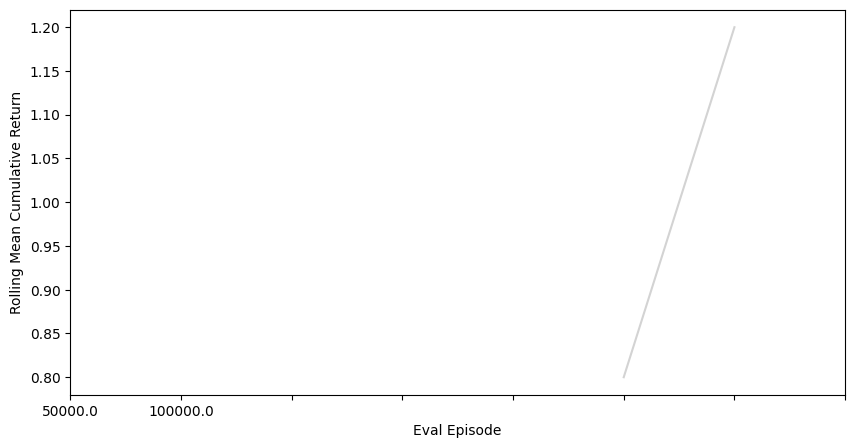

In [12]:
evaluation_log = np.load(eval_log_path + 'evaluations.npz')
evaluation_log_df = pd.DataFrame({item: [np.mean(ep) for ep in evaluation_log[item]] for item in evaluation_log.files})
ax = evaluation_log_df.loc[0:len(evaluation_log_df), 'results'].plot(color = 'lightgray', xlim = [-5, len(evaluation_log_df)], figsize = (10,5))
evaluation_log_df['results'].rolling(5).mean().plot(color = 'black', xlim = [-5, len(evaluation_log_df)])
ax.set_xticklabels(evaluation_log_df['timesteps'])
ax.set_xlabel("Eval Episode")
plt.ylabel("Rolling Mean Cumulative Return")
plt.show()

Save the trained agent.

In [13]:
agent.save("./dqn_breakout_agent")

### Evaluation

Load the saved agent (so that we can just jump to this cell and see it in action)

In [14]:
agent = sb3.dqn.DQN.load("./dqn_breakout_agent")
agent.set_env(env)

Wrapping the env in a VecTransposeImage.


Evaluate the agent in the environment

In [15]:
mean_reward, std_reward = sb3.common.evaluation.evaluate_policy(agent, 
                                                                agent.get_env(), 
                                                                n_eval_episodes=10,
                                                               render = True)
print("Mean Reward: {} +/- {}".format(mean_reward, std_reward))

Mean Reward: 2.5 +/- 1.3601470508735443


Play a slowed down instance of a game.

In [16]:
obs = env.reset()
done = False
while not done:
    action, _states = agent.predict(obs)        
    obs, reward, done, info = env.step(action)
    env.render()
    time.sleep(0.05) # these environments run very fast so slow things down for viewing!